In [47]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from pmdarima import auto_arima


Load TSLA Data

In [48]:
# Load TSLA Data
data = yf.download('TSLA', start='2015-01-01', end='2024-10-31')


[*********************100%***********************]  1 of 1 completed


In [49]:
tsla_data = data[['Close']]
tsla_data.dropna(inplace=True)

C:\Users\Firew Ayele\AppData\Local\Temp\ipykernel_12376\2920378769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data.dropna(inplace=True)


Train-Test Split

In [50]:
# Train-Test Split (80% train, 20% test)
train_size = int(len(tsla_data) * 0.8)
train, test = tsla_data[:train_size], tsla_data[train_size:]

calculate evaluation metrics

In [51]:
# Helper function to calculate evaluation metrics
def evaluate_model(test, predictions):
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    return mae, rmse, mape

# ARIMA Model

In [52]:
# Use auto_arima to find optimal (p, d, q) parameters
auto_arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
arima_order = auto_arima_model.order
print("Optimal ARIMA order:", arima_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12345.046, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12340.889, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12339.852, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12339.956, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12339.337, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12341.053, Time=0.66 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.105 seconds
Optimal ARIMA order: (0, 1, 0)


Train ARIMA model

In [53]:
# Train ARIMA model
arima_model = ARIMA(train, order=arima_order)
arima_model_fit = arima_model.fit()

c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecast

In [74]:

# Generate forecast and align with test index
arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_forecast_series = pd.Series(arima_forecast, index=test.index)

# Handle NaN values by filling them with zeros (or you could drop them, if preferred)
# test = test.fillna(0)
# arima_forecast_series = arima_forecast_series.fillna(0)
# Drop NaNs in both test and forecast series
test = test.dropna()
arima_forecast_series = arima_forecast_series.dropna()

arima_forecast_series = arima_forecast_series.reindex(test.index, fill_value=0)



c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [75]:
print("Test Index Name:", test.index.name)
print("ARIMA Forecast Series Index Name:", arima_forecast_series.index.name)


Test Index Name: Date
ARIMA Forecast Series Index Name: Date


In [76]:
print("Dates in Test not in ARIMA Forecast:", test.index.difference(arima_forecast_series.index))
print("Dates in ARIMA Forecast not in Test:", arima_forecast_series.index.difference(test.index))


Dates in Test not in ARIMA Forecast: DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)
Dates in ARIMA Forecast not in Test: DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Date', freq=None)


In [77]:
test.index = test.index.tz_convert('UTC')
arima_forecast_series.index = arima_forecast_series.index.tz_convert('UTC')


In [78]:
test = test.squeeze()  # Convert to Series if it's a single-column DataFrame
arima_forecast_series = arima_forecast_series.squeeze()


In [79]:
test.index.name = 'Date'
arima_forecast_series.index.name = 'Date'


In [80]:
mae, rmse, mape = evaluate_model(test, arima_forecast_series)
print("ARIMA Evaluation Metrics - MAE:", mae, "RMSE:", rmse, "MAPE:", mape)


ARIMA Evaluation Metrics - MAE: 207.94214132289693 RMSE: 211.4964950202064 MAPE: 100.0


# SARIMA Model

In [81]:
# Use auto_arima to find optimal SARIMA parameters
auto_sarima_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
sarima_order = auto_sarima_model.order
sarima_seasonal_order = auto_sarima_model.seasonal_order
print("Optimal SARIMA order:", sarima_order, "Seasonal order:", sarima_seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=12337.622, Time=4.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12340.889, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12340.375, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12340.797, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12339.337, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=12345.594, Time=4.39 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=12345.207, Time=5.40 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=12315.154, Time=16.71 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=12313.154, Time=14.87 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=12311.156, Time=8.73 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=12343.201, Time=3.93 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=12313.155, Time=18.20 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=12335.607, Time=9.19 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=12309.410, Time=6.35 sec
 A

Train SARIMA model

In [82]:
# Train SARIMA model
sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=sarima_seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [84]:
# Forecast
sarima_forecast = sarima_model_fit.forecast(steps=len(test))
mae, rmse, mape = evaluate_model(test, sarima_forecast)
print("SARIMA Evaluation Metrics \nMAE:", mae,  "\nRMSE:", rmse, "M\nAPE:", mape)


SARIMA Evaluation Metrics 
MAE: 45.28501024907936 
RMSE: 55.686905527812144 M
APE: nan


c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Firew Ayele\AppData\Local\Temp\ipykernel_12376\3750948995.py:5: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - predictions) / test)) * 100


# LSTM Model

In [105]:
# Data Preprocessing for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Ensure train and test are 2D
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

In [106]:
# Ensure train and test are NumPy arrays and 2D
train = train.values if hasattr(train, 'values') else np.array(train)
test = test.values if hasattr(test, 'values') else np.array(test)

# Reshape to 2D (if necessary) and scale
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [108]:
# Set up TimeseriesGenerator
n_input = 10
n_features = 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)


In [109]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(train_generator, epochs=10)

Epoch 1/10


c:\Users\Firew Ayele\Desktop\kifiya\GMF_Investments\.venv_gmf\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1969/1969 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0131
Epoch 2/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 7.0766e-04
Epoch 3/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6.0324e-04
Epoch 4/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6.1177e-04
Epoch 5/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.7172e-04
Epoch 6/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.1582e-04
Epoch 7/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.6365e-04
Epoch 8/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.2776e-04
Epoch 9/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.4678e-04
Epoch 10/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.8179e-04


In [111]:
# Save LSTM model
lstm_model.save('lstm_model.keras')

In [97]:
# Forecasting with LSTM
lstm_predictions = []
batch = train_scaled[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions.append(lstm_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[lstm_pred]], axis=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

In [99]:
# Inverse transform predictions and calculate metrics
lstm_forecast = scaler.inverse_transform(lstm_predictions)
mae, rmse, mape = evaluate_model(test.values, lstm_forecast)
print("LSTM Evaluation Metrics\nMAE:", mae, "\nRMSE:", rmse, "\nMAPE:", mape)


LSTM Evaluation Metrics
MAE: 168.22235941450162 
RMSE: 173.4016585114235 
MAPE: 88.2896340484867


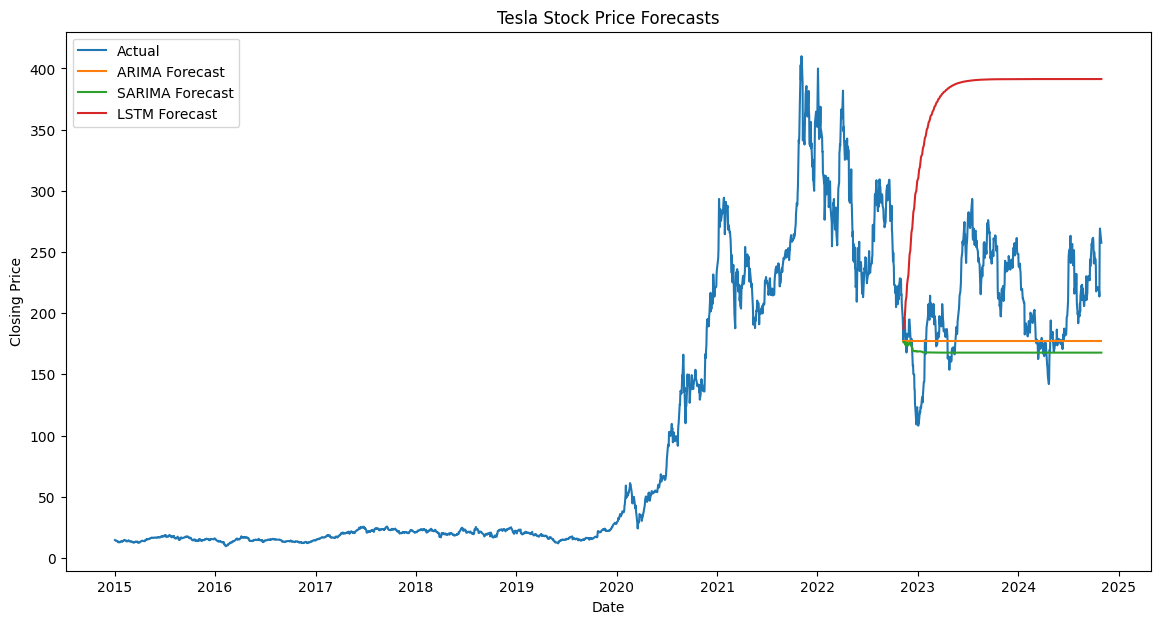

In [100]:
### Plot Forecasts ###
plt.figure(figsize=(14, 7))
plt.plot(tsla_data.index, tsla_data['Close'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.plot(test.index, lstm_forecast, label='LSTM Forecast')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.title("Tesla Stock Price Forecasts")
plt.show()